In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from SequenceEncoding import SequenceEncoding
import pickle as pkl

 # 1. Read the data

Data from: https://www.kaggle.com/datasets/shahir/protein-data-set

Code: https://www.kaggle.com/code/danofer/predicting-protein-classification/notebook

In [2]:
raw_dataset_dir = "../data_protein_classification/"
raw_seqs_filename = "pdb_data_seq.csv"
raw_metadata_filename = "pdb_data_no_dups.csv"

raw_seqs_file = os.path.join(raw_dataset_dir, raw_seqs_filename)
raw_metadata_file = os.path.join(raw_dataset_dir, raw_metadata_filename)

In [3]:
# Import Datasets
df_seq = pd.read_csv(raw_seqs_file)
df_char = pd.read_csv(raw_metadata_file)

print('Datasets have been loaded...')

Datasets have been loaded...


 # 2. Filter and process data

In [4]:
# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

In [5]:
protein_char.head()


,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0
5,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
7,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0
8,103M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0


In [6]:
protein_seq.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
7,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
8,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
11,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167,Protein
12,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [7]:
protein_seq.describe(include="all")

,structureId,chainId,sequence,residueCount,macromoleculeType
count,345180,345178,345177,345180.000000,345180
unique,127387,2348,89083,NaN,1
top,3J3Q,A,PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEG...,NaN,Protein
freq,1356,123105,2580,NaN,345180
mean,NaN,NaN,NaN,4717.870508,NaN
std,NaN,NaN,NaN,26527.126728,NaN
min,NaN,NaN,NaN,3.000000,NaN
25%,NaN,NaN,NaN,398.000000,NaN
50%,NaN,NaN,NaN,856.000000,NaN
75%,NaN,NaN,NaN,1976.000000,NaN


In [8]:
protein_char.columns


Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear'],
      dtype='object')

In [9]:
# Select  some variables to join
protein_char = protein_char[['structureId','classification','residueCount', 'resolution',
       'structureMolecularWeight','crystallizationTempK', 'densityMatthews', 'densityPercentSol', 'phValue']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()

,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [10]:
protein_char.head()

,structureId,classification,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue
2,101M,OXYGEN TRANSPORT,154,2.07,18112.80,NaN,3.09,60.20,9.0
4,102L,HYDROLASE(O-GLYCOSYL),165,1.74,18926.61,NaN,2.75,55.28,NaN
5,102M,OXYGEN TRANSPORT,154,1.84,18010.64,NaN,3.09,60.20,9.0
7,103L,HYDROLASE(O-GLYCOSYL),167,1.90,19092.72,NaN,2.70,54.46,NaN
8,103M,OXYGEN TRANSPORT,154,2.07,18093.78,NaN,3.09,60.30,9.0


In [11]:
# Join two datasets on structureId
model_f = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
model_f.head()

,classification,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,sequence
structureId,,,,,,,,,
101M,OXYGEN TRANSPORT,154,2.07,18112.80,NaN,3.09,60.20,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),165,1.74,18926.61,NaN,2.75,55.28,NaN,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,154,1.84,18010.64,NaN,3.09,60.20,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),167,1.90,19092.72,NaN,2.70,54.46,NaN,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
103M,OXYGEN TRANSPORT,154,2.07,18093.78,NaN,3.09,60.30,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [12]:
print('%d is the number of rows in the joined dataset' %model_f.shape[0])

346325 is the number of rows in the joined dataset


In [13]:
# Check NA counts
model_f.isnull().sum()

classification                   1
residueCount                     0
resolution                   16093
structureMolecularWeight         0
crystallizationTempK        102391
densityMatthews              38844
densityPercentSol            38710
phValue                      87195
sequence                         3
dtype: int64

In [14]:
# Drop rows with missing values
model_f = model_f.dropna()
print('%d is the number of proteins that have a classification and sequence' %model_f.shape[0])

214106 is the number of proteins that have a classification and sequence


HYDROLASE                               29726
TRANSFERASE                             24338
OXIDOREDUCTASE                          22578
IMMUNE SYSTEM                           11087
HYDROLASE/HYDROLASE INHIBITOR            9569
                                        ...  
DYE-BINDING PROTEIN                         1
CHAPERONE REGULATOR                         1
pyridoxal phosphate binding                 1
IMMUNE SYSTEM, LIPID BINDING PROTEIN        1
lipid transport/activator                   1
Name: classification, Length: 2458, dtype: int64


/home/jabarbero/anaconda3/envs/estancia/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


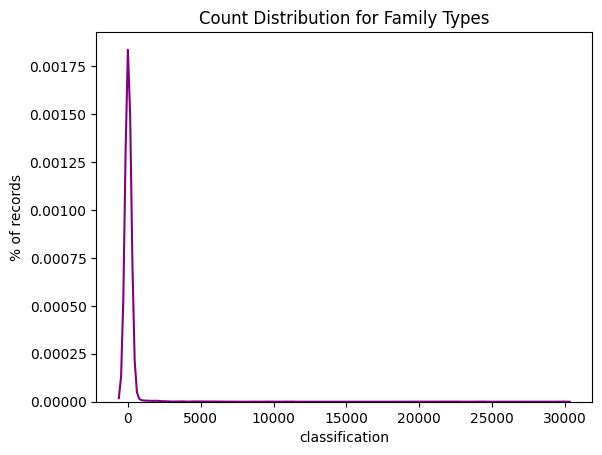

In [15]:
# Look at classification type counts
counts = model_f.classification.value_counts()
print(counts)

#plot counts
plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

There appears to be a wide distribution of counts for family types. It may be a good idea to filter for having a certain amount of recordes that are of a specific family type. 1,000 seems like a solid number that will allow a machine learning model to learn a pattern for a specific class.

In [16]:
# Get classification types where counts are over 1000
types = np.asarray(counts[(counts > 1000)].index)
print(len(types))
# Filter dataset's records for classification types > 1000
data = model_f[model_f.classification.isin(types)]
data = data.drop_duplicates(subset=["classification","sequence"])  # leaving more rows results in duplciates / index related?

print(types)
print('%d is the number of records in the final filtered dataset' %data.shape[0])

32
['HYDROLASE' 'TRANSFERASE' 'OXIDOREDUCTASE' 'IMMUNE SYSTEM'
 'HYDROLASE/HYDROLASE INHIBITOR' 'LYASE' 'TRANSCRIPTION'
 'TRANSPORT PROTEIN' 'ISOMERASE' 'VIRAL PROTEIN' 'SIGNALING PROTEIN'
 'LIGASE' 'PROTEIN BINDING' 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'
 'TRANSFERASE/TRANSFERASE INHIBITOR' 'MEMBRANE PROTEIN'
 'SUGAR BINDING PROTEIN' 'UNKNOWN FUNCTION' 'DNA BINDING PROTEIN'
 'CHAPERONE' 'STRUCTURAL PROTEIN' 'METAL BINDING PROTEIN' 'CELL ADHESION'
 'ELECTRON TRANSPORT' 'PROTEIN TRANSPORT'
 'OXIDOREDUCTASE/OXIDOREDUCTASE INHIBITOR' 'TOXIN' 'RNA BINDING PROTEIN'
 'CELL CYCLE' 'PHOTOSYNTHESIS' 'GENE REGULATION' 'DE NOVO PROTEIN']
46422 is the number of records in the final filtered dataset


In [17]:
data = data.drop_duplicates(subset=["classification","sequence"]) 
data.shape

(46422, 9)

# 3. Encodings

In [18]:
# Turn data sequences into list format
X = data.sequence.tolist()
y = data.classification.tolist()

# 3.1. One-hot encoding

In [19]:
X_onehot = [SequenceEncoding("One_hot").get_encoding(seq) for seq in X]

# 3.1. Evolutionary conservation masking

Steps:
1. Get homologue sequences for every sequence in the dataset using BLAST. They have to be saved in a specific folder named after the id in "data".
2. Align every group of homologues using Clustal Omega.
3. Get the sequence conservation values for each sequence using PyCanal.

In [20]:
data.head()

,classification,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,sequence
structureId,,,,,,,,,
1A4S,OXIDOREDUCTASE,2012,2.1,217689.59,287.0,2.43,41.00,7.5,AQLVDSMPSASTGSVVVTDDLNYWGGRRIKSKDGATTEPVFEPATG...
1A6Q,HYDROLASE,382,2.0,42707.55,277.0,2.97,59.00,5.0,MGAFLDKPKMEKHNAQGQGNGLRYGLSSMQGWRVEMEDAHTAVIGL...
1A72,OXIDOREDUCTASE,374,2.6,40658.50,277.0,2.30,46.82,8.4,STAGKVIKCKAAVLWEEKKPFSIEEVEVAPPKAHEVRIKMVATGIC...
1A8O,VIRAL PROTEIN,70,1.7,8175.72,277.0,2.21,43.80,8.0,MDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQNANP...
1ACC,TOXIN,735,2.1,82849.97,277.0,2.30,47.00,6.0,EVKQENRLLNESESSSQGLLGYYFSDLNFQAPMVVTSSTTGDLSIP...


In [21]:
# First, we need to save every sequence in the dataset as a fasta file using the structureId in the dataframe as the filename and the fasta identifier


# Create a directory to store the fasta files
fasta_dir = "../data_protein_classification/fasta_files"
if not os.path.exists(fasta_dir):
    os.makedirs(fasta_dir)

# Loop through the dataframe and save each sequence as a fasta file
for index, row in data.iterrows():
    structureId = index
    sequence = row['sequence']
    fasta_filename = structureId + ".fasta"
    fasta_file = os.path.join(fasta_dir, fasta_filename)
    with open(fasta_file, "w") as f:
        f.write(">" + structureId + "\n" + sequence)

# <span style="color:red"> DEAD END: Can't get the conservation values for each sequence.*</span>
## <span style="color:red"> You can get the homologue sequences with BLAST, but the MSA for 40000 instances would take around 1 year using Clustal Omega.</span>

In [22]:
# Run blastp as a subprocess to get sequences with significant similarity to the query sequence


from Bio.Blast.Applications import NcbiblastpCommandline

# Create a directory to store the blastp results
blastp_dir = "../data_protein_classification/blastp_results"
if not os.path.exists(blastp_dir):
    os.makedirs(blastp_dir)

# Create a directory to store the blastp results in fasta format
blastp_fasta_dir = "../data_protein_classification/blastp_fasta"
if not os.path.exists(blastp_fasta_dir):
    os.makedirs(blastp_fasta_dir)


# Call blastp as a subprocess for each fasta file in the fasta directory (this takes around 100h/4days to run)
for fasta_file in os.listdir(fasta_dir):

    
    fasta_filename = fasta_file.split(".")[0]
    blastp_filename = fasta_filename + ".blastp"
    blastp_file = os.path.join(blastp_dir, blastp_filename)
    fasta_file = os.path.join(fasta_dir, fasta_file)
    
    # Skip results already computed (to continue in case of interruption)
    if not os.path.exists(blastp_file):
    
        blastp_cline = NcbiblastpCommandline(query=fasta_file, 
                                            db="/home/jabarbero/Uniref/uniref90/uniref90", 
                                            out=blastp_file, 
                                            outfmt='6 qseqid sseqid qseq',
                                            num_threads=100)
        stdout, stderr = blastp_cline()
        # If there is an error, print the error
        if stderr:
            print(stderr)
        
        # If blastp results are empty, skip to the next fasta file
        if os.stat(blastp_file).st_size > 0:

            # Get the blastp results and reformate them into a fasta file
            blastp_results = pd.read_csv(blastp_file, sep="\t", header=None)
            blastp_results.columns = ["qseqid", "sseqid", "sseq"]

            # Save the blastp results as a fasta file
            blastp_fasta_filename = fasta_filename + ".blastp.fasta"
            blastp_fasta_file = os.path.join(blastp_fasta_dir, blastp_fasta_filename)
            with open(blastp_fasta_file, "w") as f:
                for index, row in blastp_results.iterrows():
                    f.write(">" + str(row["qseqid"]) + "_" + str(row["sseqid"]) + "\n" + str(row["sseq"]) + "\n")


: 

: 

In [ ]:
# Get the alignment for each fasta file in the blastp_fasta directory


from Bio.Align.Applications import ClustalOmegaCommandline 
import time

# Create a directory to store the aligned sequences
aligned_dir = "../data_protein_classification/clustalw_aligned_sequences"
if not os.path.exists(aligned_dir):
    os.makedirs(aligned_dir)

total_number_of_files = len(os.listdir(blastp_fasta_dir))

i = 0
for blast_fasta_filename in os.listdir(blastp_fasta_dir):

    start_time = time.time()

    i += 1
    print(f"Aligning file {i} out of {total_number_of_files}: [{blast_fasta_filename}]", end="\r")

    # Create MSA
    alignment_file = os.path.join(aligned_dir, blast_fasta_filename)
    clustalomega_cline = ClustalOmegaCommandline(infile=os.path.join(blastp_fasta_dir, blast_fasta_filename),
                                                 outfile=alignment_file,
                                                 verbose=True,
                                                 auto=True)
    stdout, stderr = clustalomega_cline()
    # If there is an error, print the error
    if stderr:
        print(stderr)

    end_time = time.time()
    print(f"Time elapsed: {end_time - start_time} seconds")

KeyboardInterrupt: 

In [ ]:
# Get the sequence conservation score for each sequence in the dataset

# Add pycanal to path
import sys
sys.path.append('PyCanal')
from pycanal import Canal

# Create a directory to store the conservation scores
conservation_dir = "../data_protein_classification/pycanal_conservation_scores"
if not os.path.exists(conservation_dir):
    os.makedirs(conservation_dir)

# For each file in the blastp fasta directory, get the conservation scores
for blastp_fasta_file in os.listdir(blastp_fasta_dir):
    # Create an instance of the Canal class
    canal = Canal(fastafile=os.path.join(blastp_fasta_dir, blastp_fasta_file), #Multiple sequence alignment (MSA) of homologous sequences
                ref=0, #Position of reference sequence in MSA, use first sequence
                startcount=0, #Position label of first residue in reference sequence
                verbose=False # Print out progress
                )

    cons_scores = {}
    # Compute conservation scores for each site in reference sequence with relative entropy method
    cons_scores["relative"] = canal.analysis(include=None, method='relative')['relative']
    cons_scores["shannon"] = canal.analysis(include=None, method='shannon')['shannon']
    cons_scores["lockless"] = canal.analysis(include=None, method='lockless')['lockless']

    # Save the conservation scores as a pickle file
    blastp_fasta_filename = blastp_fasta_file.split(".")[0]
    conservation_filename = blastp_fasta_filename + ".conservation.pkl"
    conservation_file = os.path.join(conservation_dir, conservation_filename)
    with open(conservation_file, "wb") as f:
        pkl.dump(cons_scores, f)

AssertionError: Sequences are of varying length. Ensure that sequences in fasta file have been aligned so that they are of the same length.